In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import tensorflow_addons as tfa
import random
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image

pd.set_option("display.max_columns", None)

print('success')

success


In [ ]:
print(f"PyTorch Lightning version: {pl.__version__}")

In [2]:
train = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/train.csv')
test = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/sample_submission.csv')

In [3]:
train['labels'] = train['labels'].apply(lambda string: string.split(' '))
train

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
18627,fffb900a92289a33.jpg,[healthy]
18628,fffc488fa4c0e80c.jpg,[scab]
18629,fffc94e092a59086.jpg,[rust]
18630,fffe105cf6808292.jpg,"[scab, frog_eye_leaf_spot]"


Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               2151
frog_eye_leaf_spot    4352
healthy               4624
powdery_mildew        1271
rust                  2077
scab                  5712
dtype: int64
['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


<AxesSubplot:>

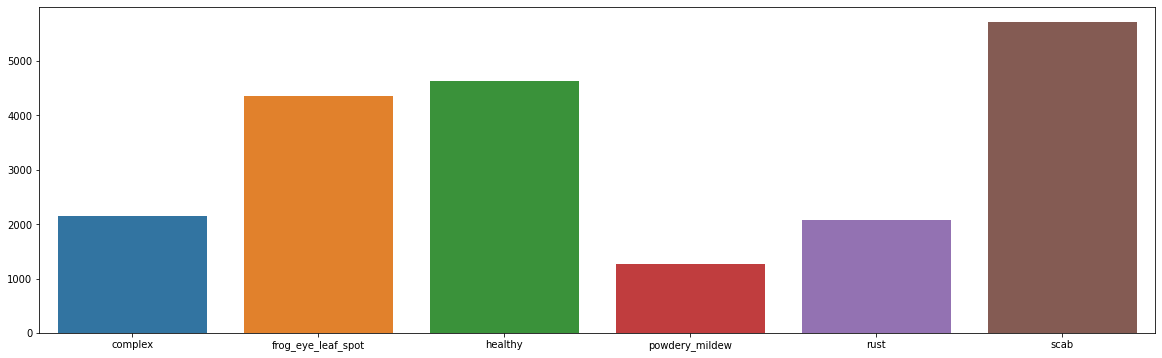

In [4]:
s = list(train['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
print(trainx.columns)
print(trainx.sum())

labels = list(trainx.sum().keys())
print(labels)
label_counts = trainx.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.barplot(x= labels, y= label_counts, ax=ax)

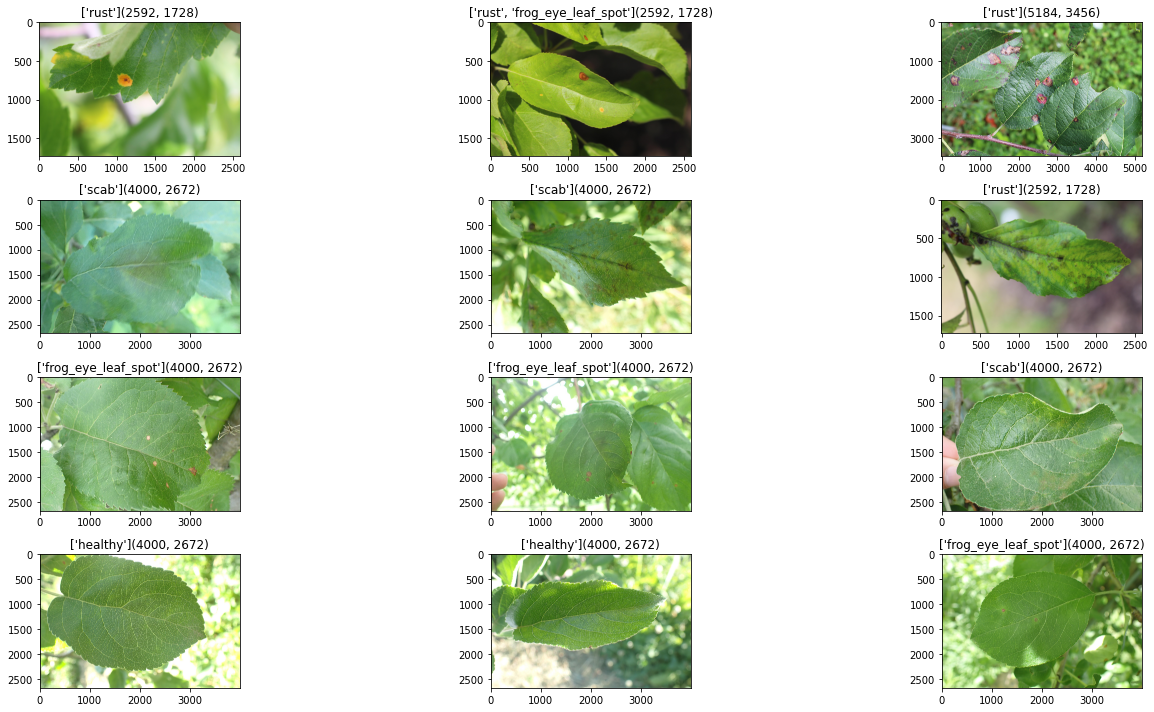

In [5]:
fig1 = plt.figure(figsize=(26,10))

for i in range(1, 13):
    
    rand =  random.randrange(1, len(list(train['image'])))
    sample = os.path.join('/kaggle/input/plant-pathology-2021-fgvc8/train_images/', train['image'][rand])
    
    img = Image.open(sample)
    
    ax = fig1.add_subplot(4,3,i)
    ax.imshow(img)
    
    title = f"{train['labels'][rand]}{img.size}"
    plt.title(title)
    
    fig1.tight_layout()

In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.0,
                            rotation_range=5,
                            zoom_range=0.1,
                            shear_range=0.05,
                            horizontal_flip=True,
                            validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    train,
    directory='/kaggle/input/plant-pathology-2021-fgvc8/train_images',
    subset='training',
    x_col='image',
    y_col='labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=444
    )

#'../input/plant-pathology-2021-fgvc8/train_images'
valid_generator = datagen.flow_from_dataframe(
    train,
    directory='/kaggle/input/plant-pathology-2021-fgvc8/train_images',
    subset='validation',
    x_col='image',
    y_col='labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=444
    )

Found 16769 validated image filenames belonging to 6 classes.
Found 1863 validated image filenames belonging to 6 classes.


In [7]:
import h5py

In [8]:
seed = 1200
tf.random.set_seed(seed)

# weights_path = '../input/keras-pretrained-models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
# model = keras.applications.InceptionResNetV2(weights=weights_path, include_top=False, input_shape=(224, 224, 3))
model = keras.applications.NASNetMobile(input_shape=(224, 224, 3), include_top=False, weights='imagenet', classes=1000)
print(model.input)
print(model.output)

2022-03-20 07:10:20.400488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 07:10:20.522841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 07:10:20.523638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 07:10:20.524805: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

20004864/19993432 [==============================] - 0s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1056), dtype=tf.float32, name=None), name='activation_187/Relu:0', description="created by layer 'activation_187'")


In [9]:
new_model = tf.keras.Sequential([
    model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(6, 
        kernel_initializer=keras.initializers.RandomUniform(seed=seed),
        bias_initializer=keras.initializers.Zeros(), name='dense_top', activation='sigmoid')
])

# Freezing the weights
for layer in new_model.layers[:-1]:
    layer.trainable=False
    
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1056)              0         
_________________________________________________________________
dense_top (Dense)            (None, 6)                 6342      
Total params: 4,276,058
Trainable params: 6,342
Non-trainable params: 4,269,716
_________________________________________________________________


In [10]:
from tensorflow.keras.callbacks import EarlyStopping
import PIL
f1 = tfa.metrics.F1Score(num_classes=6,average='macro')

new_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',f1])
callbacks = keras.callbacks.EarlyStopping(monitor=f1, patience=4, mode='max', restore_best_weights=True)
history = new_model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    epochs=65,
                    steps_per_epoch=train_generator.samples//256, # = 58
                    validation_steps=valid_generator.samples//128,
                    callbacks=callbacks)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-03-20 07:10:45.128152: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/65


2022-03-20 07:11:03.009022: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


65/65 [==============================] - 437s 6s/step - loss: 0.4397 - accuracy: 0.3524 - f1_score: 0.2298 - val_loss: 0.4017 - val_accuracy: 0.4018 - val_f1_score: 0.3001
Epoch 2/65
65/65 [==============================] - 420s 6s/step - loss: 0.3879 - accuracy: 0.4596 - f1_score: 0.3786 - val_loss: 0.3800 - val_accuracy: 0.4598 - val_f1_score: 0.4093
Epoch 3/65
65/65 [==============================] - 395s 6s/step - loss: 0.3674 - accuracy: 0.4904 - f1_score: 0.4280 - val_loss: 0.3563 - val_accuracy: 0.5402 - val_f1_score: 0.4723
Epoch 4/65
65/65 [==============================] - 385s 6s/step - loss: 0.3461 - accuracy: 0.5519 - f1_score: 0.4841 - val_loss: 0.3376 - val_accuracy: 0.5558 - val_f1_score: 0.5053
Epoch 5/65
65/65 [==============================] - 390s 6s/step - loss: 0.3345 - accuracy: 0.5573 - f1_score: 0.5021 - val_loss: 0.3523 - val_accuracy: 0.5067 - val_f1_score: 0.4468
Epoch 6/65
65/65 [==============================] - 377s 6s/step - loss: 0.3355 - accuracy: 0.56

In [23]:
test = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')

for img_name in tqdm(test['image']):
    path = '../input/plant-pathology-2021-fgvc8/test_images/'+str(img_name)
    with PIL.Image.open(path) as img:
        img = img.resize((256,256))
        img.save(f'./{img_name}')

100%|██████████| 3/3 [00:00<00:00,  4.37it/s]


In [25]:

test_data = datagen.flow_from_dataframe(
    test,
    directory = './',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (256,256),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

preds = new_model.predict(test_data)
print(preds)
preds = preds.tolist()

indices = []
for pred in preds:
    temp = []
    for category in pred:
        if category>=0.3:
            temp.append(pred.index(category))
    if temp!=[]:
        indices.append(temp)
    else:
        temp.append(np.argmax(pred))
        indices.append(temp)
    
print(indices)

Found 3 validated image filenames.
[[0.07870501 0.02825795 0.00554854 0.00572076 0.49380934 0.88196933]
 [0.1765582  0.4911383  0.00364841 0.00431574 0.57717055 0.21356595]
 [0.29713592 0.49069583 0.05480914 0.00890297 0.09821882 0.40024063]]
[[4, 5], [1, 4], [1, 5]]


In [26]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

testlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    testlabels.append(' '.join(temp))

print(testlabels)

{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
['rust scab', 'frog_eye_leaf_spot rust', 'frog_eye_leaf_spot scab']


In [27]:
arr1 = history.history['loss']
result1 = sum(arr1)
print(f"loss_av : {result1 / len(arr1)}")

arr2 = history.history['accuracy']
result2 = sum(arr2)
print(f"accuracy_av : {result2 / len(arr2)}")

arr3 = history.history['val_loss']
result3 = sum(arr3)
print(f"val_loss_av : {result3 / len(arr3)}")

arr4 = history.history['val_accuracy']
result4 = sum(arr4)
print(f"val_accuracy_av : {result4 / len(arr4)}")

loss_av : 0.29603316600506124
accuracy_av : 0.6272050064343673
val_loss_av : 0.2912368960105456
val_accuracy_av : 0.6324862654392536


In [28]:
sub = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')
sub['labels'] = testlabels
sub.to_csv('submission.csv', index=False)
sub

,image,labels
0,85f8cb619c66b863.jpg,rust scab
1,ad8770db05586b59.jpg,frog_eye_leaf_spot rust
2,c7b03e718489f3ca.jpg,frog_eye_leaf_spot scab
